# A Map for the TRACER proposal 

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import cartopy.io.img_tiles as cimgt
import pandas as pd
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import numpy as np
from metpy.calc import reduce_point_density
import matplotlib.patches as mpatches
from pyproj import Geod
import shapely.geometry as sgeom

%matplotlib inline

In [2]:
def namefilter(dframe, radius):
    proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])
    point_locs = proj.transform_points(ccrs.PlateCarree(), dframe['Longitude'].values, dframe['Latitude'].values)
    indexes_dc = reduce_point_density(point_locs, radius)
    ndframe = dframe[indexes_dc]
    return ndframe

def plot_points_from_df(dframe, sym='r*', ssize=12, label=None):
    iamfirst = True
    for index, row in dframe.iterrows():
        if iamfirst:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize, label=label)
            iamfirst = False
        else:
            plt.plot(row['Longitude'], row['Latitude'], sym,
                     transform=ccrs.PlateCarree(), markersize=ssize)


def plot_text(dframe, dx=0.01, dy=0.01, tcol='c'):
    for index, row in dframe.iterrows():
        plt.text(row['Longitude']+dx, row['Latitude']+dy, row['SiteName'],transform=ccrs.PlateCarree(),
                fontsize=20, color=tcol, alpha=1, weight='bold')
    

 # plot a scale bar with 4 subdivisions on the left side of the map
def scale_bar_left(ax, bars=4, length=None, location=(0.1, 0.05), linewidth=3, col='black',
                  fs=None, oset=2000):
    """
    ax is the axes to draw the scalebar on.
    bars is the number of subdivisions of the bar (black and white chunks)
    length is the length of the scalebar in km.
    location is left side of the scalebar in axis coordinates.
    (ie. 0 is the left side of the plot)
    linewidth is the thickness of the scalebar.
    color is the color of the scale bar
    """
    # Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    # Make tmc aligned to the left of the map,
    # vertically at scale bar location
    sbllx = llx0 + (llx1 - llx0) * location[0]
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    # Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    # Calculate a scale bar length if none has been given
    # (Theres probably a more pythonic way of rounding the number but this works)
    if not length:
        length = (x1 - x0) / 5000  # in km
        ndim = int(np.floor(np.log10(length)))  # number of digits in number
        length = round(length, -ndim)  # round to 1sf

        # Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']:
                return int(x)
            else:
                return scale_number(x - 10 ** ndim)

        length = scale_number(length)

    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx, sbx + length * 1000 / bars]
    # Plot the scalebar chunks
    barcol = 'yellow'
    for i in range(0, bars):
        # plot the chunk
        ax.plot(bar_xs, [sby, sby], transform=tmc, color=barcol, linewidth=linewidth)
        # alternate the colour
        if barcol == 'yellow':
            barcol = 'blue'
        else:
            barcol = 'yellow'
        # Generate the x coordinate for the number
        bar_xt = sbx + i * length * 1000 / bars
        # Plot the scalebar label for that chunk
        ax.text(bar_xt, sby + oset, str(round(i * length / bars)), transform=tmc,
                horizontalalignment='center', verticalalignment='bottom',
                color=col, fontsize=fs)
        # work out the position of the next chunk of the bar
        bar_xs[0] = bar_xs[1]
        bar_xs[1] = bar_xs[1] + length * 1000 / bars
    # Generate the x coordinate for the last number
    bar_xt = sbx + length * 1000
    # Plot the last scalebar label
    ax.text(bar_xt, sby + oset , str(round(length)), transform=tmc,
            horizontalalignment='center', verticalalignment='bottom',
            color=col, fontsize=fs)
    # Plot the unit label below the bar
    bar_xt = sbx + length * 1000 / 2
    bar_yt = y0 + (y1 - y0) * (location[1] / 4)
    ax.text(bar_xt, bar_yt, 'km', transform=tmc, horizontalalignment='center',
            verticalalignment='bottom', color=col, fontsize=fs)   

In [3]:
df = pd.read_csv('../data/HGB_Monitors.txt')

In [4]:
all_met = pd.read_csv('../data/inst_at_cams_sites.csv')

In [5]:
cams_locs = pd.read_csv('../data/CAMS_locations.csv')

In [6]:
lalo_cams = cams_locs['LongitudeLatitude']
lat_cams = [float(this_item.split(',')[1]) for this_item in lalo_cams]
lon_cams = [float(this_item.split(',')[0]) for this_item in lalo_cams]
cams_locs['Longitude'] = lon_cams
cams_locs['Latitude'] = lat_cams


In [7]:
good_met = all_met[np.logical_not(pd.isna(all_met.CAMS))]
good_met['Longitude'] = np.zeros(len(good_met))
good_met['Latitude'] = np.zeros(len(good_met))
good_met['known_loc'] = np.zeros(len(good_met))


i=0
for index, row in good_met.iterrows():
    #print(index, row.CAMS)
    try:
        col = cams_locs['CAMS'][cams_locs.CAMS == int(row.CAMS)].index[0]
        good_met['Latitude'][index] = cams_locs['Latitude'][col]
        good_met['Longitude'][index] = cams_locs['Longitude'][col]
        good_met['known_loc'][index] = 1
    except:
        print('Cams unknown')
    #good_met['Latitude'][i] = cams_locs

good_met = good_met[good_met.known_loc > 0.1]

/Users/scollis/anaconda3/envs/tracer-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/scollis/anaconda3/envs/tracer-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/scollis/anaconda3/envs/tracer-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

Cams unknown
Cams unknown
Cams unknown
Cams unknown
Cams unknown
Cams unknown
Cams unknown


In [8]:

inst_names = {}
is_inst = ['PMC Cab Temp', 'Ext Coef', 'D/N', 'Pres WX', 'Pres WX Obs',
       'WSA', 'WSR', 'WDR', 'Max Gust', 'STD WD', 'Out Temp', 'Dew Point',
       'Int Temp', 'Rel Humid', 'Vis', 'Slr Rad', 'UV Rad', 'Net Rad', 'Press',
       'Precip']

does_it_have = {}

for an_instrument in is_inst:
    availability = good_met[an_instrument] > 0.9
    does_it_have.update({an_instrument : availability})


In [9]:
basic_met = np.logical_and(does_it_have['Out Temp'], does_it_have['WDR'])
rad = np.logical_and(does_it_have['Slr Rad'], basic_met)
rad_sites = good_met[rad]
basic_sites = good_met[basic_met]

In [10]:
"""
AMF1 at La Porte airport 29.666944N, -95.063611W
C-SAPR2 at Manvel-Croix Park, 29.520278N, -95.392500W
ANC site near Hungerford Texas, 29.3991N, -96.0769W
KHGX 29.4719  -95.0792 
"""

'\nAMF1 at La Porte airport 29.666944N, -95.063611W\nC-SAPR2 at Manvel-Croix Park, 29.520278N, -95.392500W\nANC site near Hungerford Texas, 29.3991N, -96.0769W\nKHGX 29.4719  -95.0792 \n'

In [11]:
arm_sites = pd.DataFrame({'Latitude' : [29.666944, 29.520278, 29.3991],
                         'Longitude' : [-95.063611, -95.392500, -96.0769],
                         'SiteName' : ['AMF1 Proposed', 'C-SAPR2 Proposed', 'ANC profiling site']})

nexrad_sites = pd.DataFrame({'Latitude' : [29.4719],
                         'Longitude' : [-95.0792],
                         'SiteName' : ['KHGX']})

In [12]:
def circle(geod, lon, lat, radius, n_samples=360):
    """
    Return the coordinates of a geodetic circle of a given
    radius about a lon/lat point.

    Radius is in meters in the geodetic's coordinate system.

    """
    lons, lats, back_azim = geod.fwd(np.repeat(lon, n_samples),
                                     np.repeat(lat, n_samples),
                                     np.linspace(360, 0, n_samples),
                                     np.repeat(radius, n_samples),
                                     radians=False,
                                     )
    return lons, lats

def rring(radius_km):
    geod = Geod(ellps='WGS84')
    n_samples = 80
    geoms = []
    lons, lats = circle(geod, arm_sites['Longitude'][1], arm_sites['Latitude'][1], radius_km * 1e3, n_samples)
    geoms.append(sgeom.Polygon(zip(lons, lats)))

    plt.gca().add_geometries(geoms, ccrs.PlateCarree(), facecolor='none',
                             edgecolor='k', alpha=1, linewidth=2)


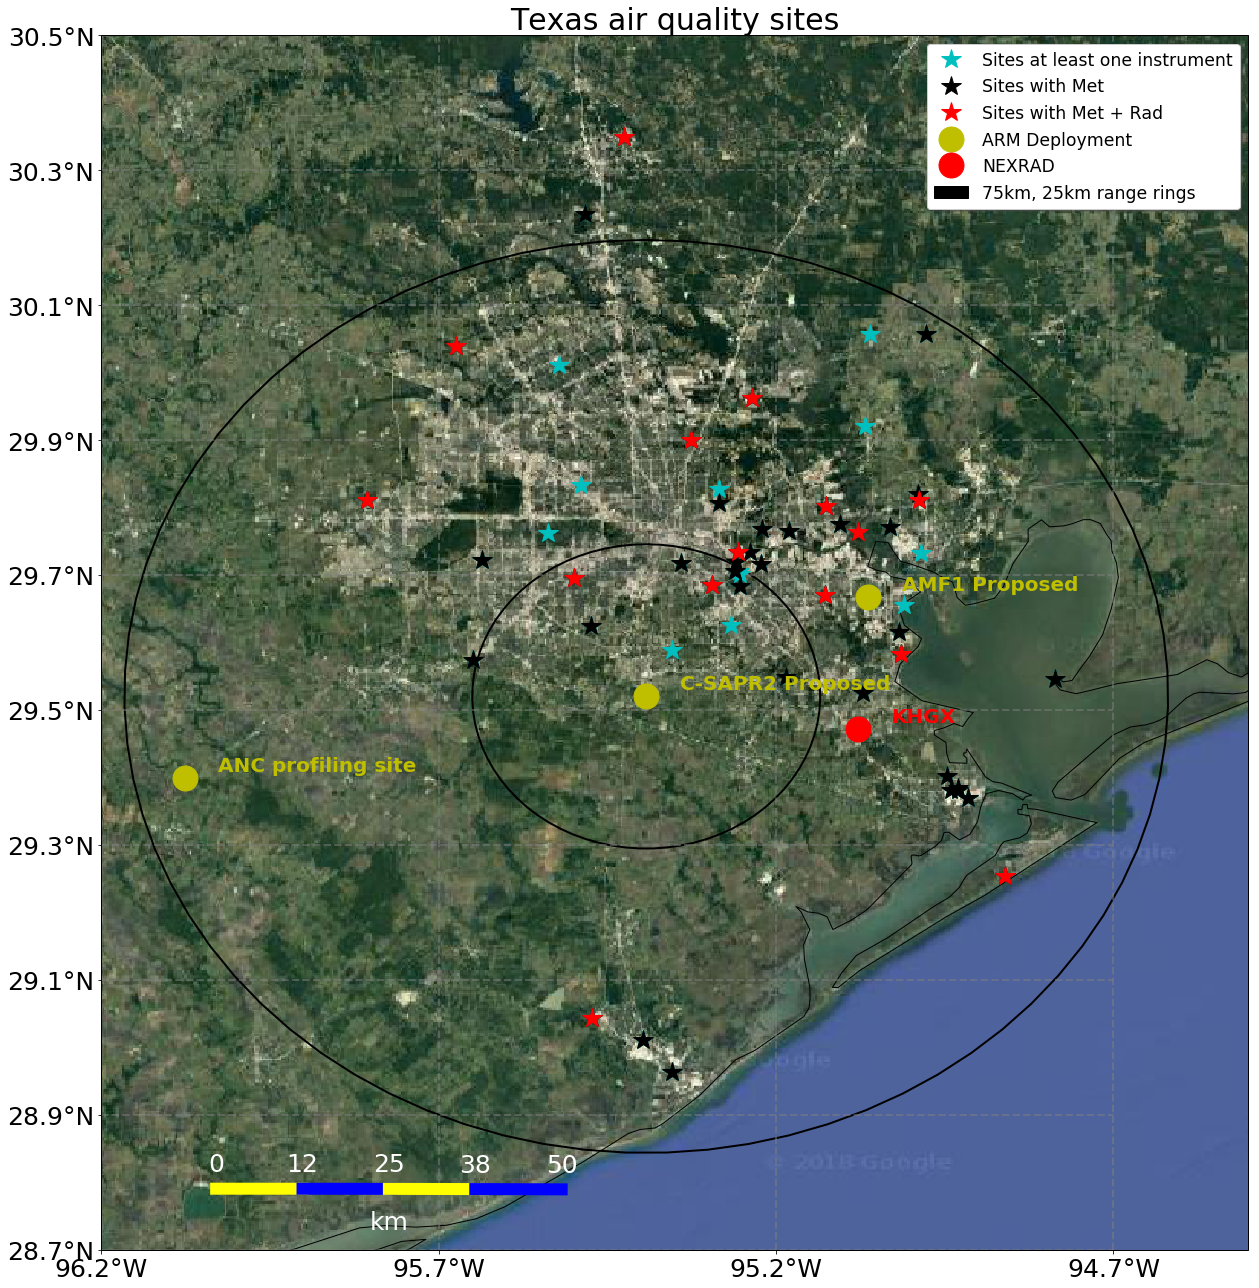

In [13]:
i = 0
plt.figure(figsize=[20,18])
ax = plt.axes(projection=ccrs.PlateCarree())

ex = [-96.2, -94.5, 28.7, 30.50001]

ax.set_extent(ex)

lat_lines = np.arange(np.around(ex[2], decimals=1), 
                      ex[3], .2)
lon_lines = np.arange(np.around(ex[0],decimals=1),
                      ex[1], .5)

#lat_lines = np.concatenate((lat_lines, np.array([31.])))


# Put a background image on for nice sea rendering.
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', name='coastline')


ax.add_feature(coast, edgecolor='k', facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

request = cimgt.GoogleTiles(style='satellite')
ax.add_image(request, 9, zorder=0)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

ax.set_xticks(lon_lines, crs=ccrs.PlateCarree())
ax.set_yticks(lat_lines, crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--',
                 xlocs=lon_lines, ylocs=lat_lines)





plot_points_from_df(good_met, 'c*', ssize=20, label='Sites at least one instrument')
plot_points_from_df(basic_sites, 'k*', ssize=20, label='Sites with Met')
plot_points_from_df(rad_sites, 'r*', ssize=20, label='Sites with Met + Rad')

plot_points_from_df(arm_sites, 'yo', ssize=25, label='ARM Deployment')
plot_text(arm_sites, dx=0.05, tcol='y')


plot_points_from_df(nexrad_sites, 'ro', ssize=25, label='NEXRAD')
plot_text(nexrad_sites, dx=0.05, tcol='r')


rring(75)
rring(25)

extraString = '75km, 25km range rings'
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(mpatches.Patch(color='k', label=extraString))



scale_bar_left(plt.gca(), linewidth=12, fs=25, col='white', length=50)

plt.legend(shadow=True, fontsize='xx-large', handles=handles)
plt.title('Texas air quality sites', fontsize=30)
plt.tight_layout()
plt.savefig('../images/texas_HGB_sites.png')
plt.show()


In [14]:
good_met


,CAMS,PMC Cab Temp,Ext Coef,D/N,Pres WX,Pres WX Obs,WSA,WSR,WDR,Max Gust,...,Vis,Slr Rad,UV Rad,Net Rad,Press,Precip,CAMS.1,Longitude,Latitude,known_loc
0,1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1,-95.221,29.768,1.0
1,8,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,1.0,NaN,8,-95.326,29.901,1.0
3,11,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,11,-95.397,29.011,1.0
4,15,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,15,-95.126,29.802,1.0
6,26,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,26,-95.674,30.039,1.0
7,35,4.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,35,-95.128,29.670,1.0
10,45,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,45,-95.015,29.583,1.0
12,53,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,53,-95.499,29.696,1.0
13,78,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,78,-95.425,30.350,1.0
15,84,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,84,-95.393,29.520,1.0
